In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

In [3]:
# Создаём обучающую выборку
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

In [4]:
# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

DecisionTreeRegressor(max_depth=3)

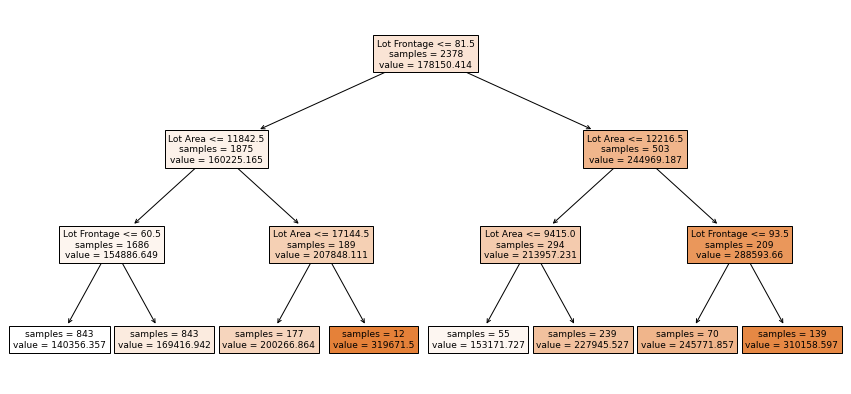

In [5]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

Построим диаграмму рассеяния и визуализируем то, как дерево решений разделяет пространство факторов на прямоугольные области

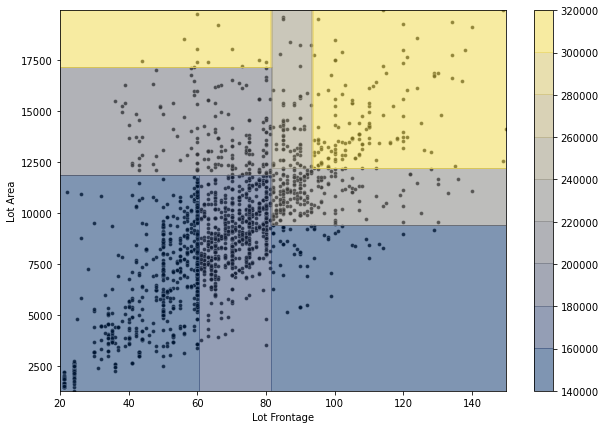

In [6]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

Давайте посмотрим на пример разделяющей поверхности дерева решений в случае задачи классификации 
Воспользуемся данными о банкнотах из Banknote Authentication Dataset.

В качестве примера для визуализации из всех характеристик, описывающих изображения банкнот, будем использовать:
- Variance (дисперсию);
- Skewness (асимметрию).

Наша цель — предсказать, является ли банкнота фальшивой (Class): 1 — фальшивая, 0 — подлинная. Файл с данными вы можете скачать здесь.

In [7]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('data/bill_authentication.csv')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

In [8]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

DecisionTreeClassifier(max_depth=4)

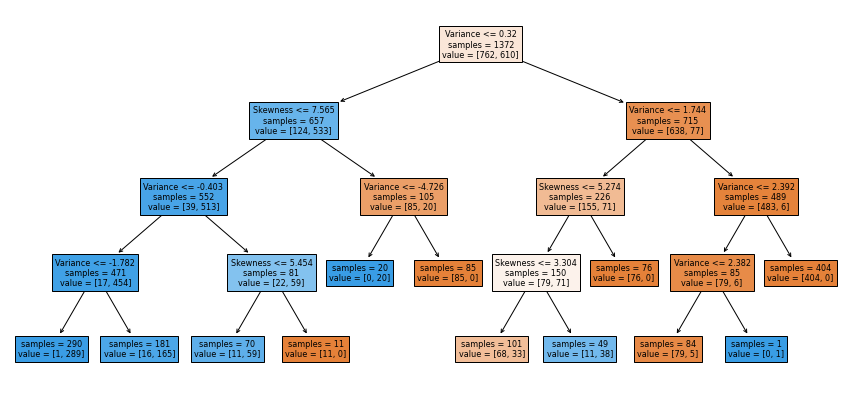

In [9]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

Построим диаграмму рассеяния и визуализируем то, как дерево решений разделяет пространство факторов на прямоугольные области. Для этого шага мы реализовали функцию функцию plot_decision_bound_classification():

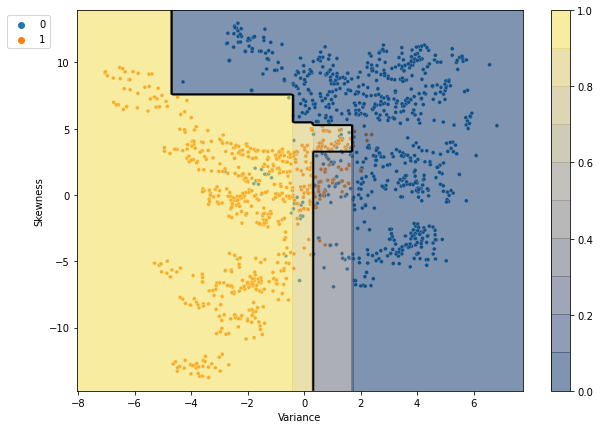

In [10]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

### 3. Алгоритм CART: параметры разбиения
CART (Classification and Regression Tree) — это алгоритм, предназначенный для построения `бинарных деревьев решений`. Он очень похож на C4.5, однако, в отличие от последнего, предназначен как для задач классификации, так и для задач регрессии. CART важен для нас, поскольку именно он используется для построения моделей решающих деревьев в sklearn.

Решаем задачу построения решающего пня: дерева с глубиной 1.

Будем рассматривать простые предикаты вида:
$$B(x_j, t)=[x_j \leqslant t]$$
Введем некоторую меру неоднородности $G(X, y, w)$, которая будет  показывать, насколько большой разброс целевой переменной $y$ для объектов из множества $X$ наблюдается в дочерних вершинах при параметрах сплита $w$. 

Которая будет  показывать, насколько большой разброс целевой переменной $y$ для объектов из множества X наблюдается в дочерних вершинах при параметрах сплита $w$. 

Параметры $w=(j, t)$ можно найти простым перебором. В качестве кандидатов на пороговое значение $t$ можно рассматривать среднее значением между двумя соседними уникальными значениями отсортированного фактора $x_j$. 

Для каждого из возможных предикатов $B(x_j, t)$ нам необходимо подсчитать значение неоднородности $G(X, y,w)$ на всей выборке и определить такую комбинацию $w_{opt}=(j_{opt}, t_{opt})$, которая дает минимум:

$$w_{opt} = argmin_w(G(X, y, w))$$

Псевдокод алгоритма поиска оптимальных параметров:
```
min_loss = inf
optimal_split_params = None
for j in range(M):
    thresholds = find_candidates_for_thresholds(X[:, j], y)
    for t in thresholds:
        split_params = (j, t)
        loss = calculate_loss(X, y, split_params)
        if loss < min_loss:
            min_loss = loss
            optimal_split_params = split_params
```

Алгоритм поиска кандидатов в параметры разбиения:
1. Сортировать числовой фактор $x_j$ по возрастанию:
$$\{x_{ij} | x_{ij}<x_{(i+1)j}\} $$
2. Вычислить среднее между двумя соседними уникальными значениями фактора:
$$\{x_{ij}^{mean}| x_{ij}^{mean}=\frac{(x_{ij}+x_{(i+1)j})}{2}\}$$
3. В качестве кандидатов на пороговые значений t выбираются только те значения, при которых целевой признак меняет свое значение.
$$\{x_{ij}^{mean}| y_i-y_{(i+1)} \neq 0\}$$ 

### КАНДИДАТЫ В ПАРАМЕТРЫ РАЗБИЕНИЯ
Псевдокод  алгоритма будет иметь вид (запускать его не нужно):
```
min_loss = inf
optimal_split_params = None
for j in range(M):
    thresholds = find_candidates_for_thresholds(X[:, j], y)
    for t in thresholds:
        split_params = (j, t)
        loss = calculate_loss(X, y, split_params)
        if loss < min_loss:
            min_loss = loss
            optimal_split_params = split_params
```


In [16]:
# Теперь, когда мы научились считать вручную, настало время реализовать на Python 
# полученный нами способ определения кандидатов в параметры предиката. Будем это 
# делать на примере признака возраста:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']

In [17]:
# Сначала отсортируем фактор по возрастанию с помощью метода sort_values() и 
# удалим из него дубликаты с помощью метода drop_duplicates():
x = x.sort_values().drop_duplicates()
print(x.values)

[17 18 20 25 29 31 38 49 55 64]


In [18]:
# Для вычисления скользящего среднего в Pandas можно воспользоваться комбинацией 
# методов rolling() и mean(). В методе rolling() необходимо указать окно, в котором 
# считается среднее (в нашем случае оно равно 2):
x_roll_mean = x.rolling(2).mean()
print(x_roll_mean.values)

[ nan 17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


In [19]:
# В результате вычисления скользящего среднего всегда будет образовываться один 
# пропуск. Для его исключения воспользуемся методом dropna():
x_roll_mean = x_roll_mean.dropna()
print(x_roll_mean.values)

[17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


In [20]:
# Наконец, необходимо отфильтровать x так, чтобы в результат попали только те значения,
# при переходе через которые целевая переменная меняется. Для этого мы отсортируем y в 
# соответствии с индексами x, затем вычислим разницу между соседними значениями y 
# с помощью метода diff(). После этого произведём фильтрацию:

y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
print(candidates.values)

[17.5 19.  22.5 30.  34.5 43.5]


In [21]:
# Удобнее будет оформить полученный алгоритм в виде функции find_candidates_for_thresholds().
# Она будет принимать на вход фактор x и целевую переменную y и возвращать кандидатов в 
# пороговые значения для y в виде numpy-массива:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

In [22]:
print(find_candidates_for_thresholds(data['age'], data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


#### Задание 3.4
Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

In [42]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, # количество объектов
    random_state=42) # генератор случайных чисел
ames_sample.index = pd.Index(range(ames_sample.shape[0]))

Найдите уникальных кандидатов на пороговое значение $t$ для фактора $x_1$ (Lot Frontage).

In [46]:
find_candidates_for_thresholds(ames_sample['Lot Frontage'],ames_sample.SalePrice)

array([ 53.,  58.,  61.,  65.,  69.,  71.,  76.,  86.,  94., 101.])

#### Задание 3.5
Для части датасета о домах в Айове из предыдущего задания найдите уникальных кандидатов на пороговое значение  для фактора $x_2$ (Lot Area).

In [47]:
find_candidates_for_thresholds(ames_sample['Lot Area'],ames_sample.SalePrice)

array([ 5508. ,  7153. ,  7425. ,  7949. ,  8405.5,  8526.5,  8850. ,
        9137.5,  9466. , 10051.5, 10507. , 10834. , 11365. , 12288. ])

### 4. Алгоритм CART: неоднородность, критерии информативности

In [50]:
# Для начала создадим функцию для расчёта среднего квадрата ошибки — squared_error(). 
# Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное 
# для входных данных.
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

In [51]:
# Далее нам необходимо реализовать функцию split(), которая разбивает выборку  
# по предикату  с параметрами разделения (split_params) на левую и правую части:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

In [52]:
# Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход 
# выборку — X и y, параметры разбиения — split_params, а также criterion — функцию, 
# по которой рассчитывается критерий информативности (у нас это функция squared_error()). 
# Результатом работы функции будет взвешенная неоднородность после разбиения.
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

In [53]:
# Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде 
# цикла отбор кандидатов в параметры разбиения и найти оптимальные из них. За данный шаг
# будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y)
# и возвращать оптимальные параметры разбиения, при которых значение взвешенной 
# неоднородности минимально, а также значение этой неоднородности.
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

### Задание 4.3
Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

In [54]:
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, 
    random_state=42
)
ames_sample.index = pd.Index(range(ames_sample.shape[0]))
# Создаем обучающую выборку
X = ames_sample[['Lot Frontage', 'Lot Area']]
y = ames_sample['SalePrice']

Найдите оптимальные для построения решающего пня параметры разбиения  и . В качестве критерия информативности используйте квадратичную ошибку.

In [55]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0


In [56]:

calculate_weighted_impurity(X, y, split_params = optimal_split_params, criterion=squared_error)

1414654917.0222223

In [57]:
optimal_split_params

(0, 71.0)